In [1]:
% pylab inline
from numpy import linalg as LA
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import glob
from tqdm import tqdm_notebook
import os
import sklearn.preprocessing as prep
import pickle
import joblib
import tensorflow as tf

def min_max_scale(X):
    preprocessor = prep.MinMaxScaler().fit(X)
    X_scaled = preprocessor.transform(X)
    return X_scaled

Populating the interactive namespace from numpy and matplotlib


## import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
train_tf_records_file = ['/Z/personal-folders/interns/saket/tf-datasets/baidu_images/level0_128px/train-00000-of-00002',
                         '/Z/personal-folders/interns/saket/tf-datasets/baidu_images/level0_128px/train-00001-of-00002']

validation_tf_records_file = ['/Z/personal-folders/interns/saket/tf-datasets/baidu_images/level0_128px/validation-00000-of-00002',
                              '/Z/personal-folders/interns/saket/tf-datasets/baidu_images/level0_128px/validation-00001-of-00002']


training_dataset = tf.data.TFRecordDataset(train_tf_records_file)
validation_dataset = tf.data.TFRecordDataset(validation_tf_records_file)
"""
dataset = dataset.map(_parse_function)  # Using _parse_function from your question.
dataset = dataset.batch(20) 

reader = tf.TFRecordReader()
_, serialized = reader.read(filename_queue)
features = tf.parse_single_example(
    serialized,
    features={
        'label': tf.FixedLenFeature([], tf.string),
        'image': tf.FixedLenFeature([], tf.string)
    }
)
record_image = tf.decode_raw(features['image'], tf.uint8)

image = tf.reshape(record_image, [500, 500, 1])
label = tf.cast(features['label'], tf.string)
min_after_dequeue = 10
batch_size = 1000
capacity = min_after_dequeue + 3 * batch_size
image_batch, label_batch = tf.train.shuffle_batch(
    [image, label], batch_size=batch_size, capacity=capacity, min_after_dequeue=min_after_dequeue
)
"""
WIDTH = 128
HEIGHT = 128
DEPTH = 3
def preprocess(image):
    return image/255.0

def parser(serialized_example):
    """Parses a single tf.Example into image and label tensors."""
    
    features = tf.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.FixedLenFeature([], tf.string),
            'image/class/label': tf.FixedLenFeature([], tf.int64),
        })
    image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
    
    #image.set_shape([DEPTH * HEIGHT * WIDTH])
    image = tf.reshape(image, (-1, DEPTH * HEIGHT * WIDTH))
    print(image.shape)
    # Reshape from [depth * height * width] to [depth, height, width].
    #image = tf.cast(
    #    tf.transpose(tf.reshape(image, [DEPTH, HEIGHT, WIDTH]), [1, 2, 0]),
    #    tf.float32)
    image = tf.cast(
        image,
        tf.float32)
    label = tf.cast(features['image/class/label'], tf.int32)

    # Custom preprocessing.
    image = preprocess(image)

    return image, label

batch_size = 32
training_dataset = training_dataset.map(
    parser, 
    num_parallel_calls=batch_size)

# Potentially shuffle records.
# Batch it up.
training_dataset = training_dataset.batch(batch_size)
training_iterator = training_dataset.make_one_shot_iterator()
#training_image_batch, training_label_batch = train_iterator.get_next()
validation_dataset = validation_dataset.map(
    parser, 
    num_parallel_calls=batch_size)
validation_dataset = validation_dataset.batch(batch_size)

(?, 49152)
(?, 49152)


In [3]:
training_iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                                    training_dataset.output_shapes)
training_next_batch = training_iterator.get_next()
training_init_op = training_iterator.make_initializer(training_dataset)
validation_init_op = training_iterator.make_initializer(validation_dataset)



In [4]:
config = tf.ConfigProto(
    device_count = {'GPU': 0}
)
config.gpu_options.allocator_type = 'BFC'
#config

IMAGE_WIDTH = 128 
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3

class VAE(object):
    def __init__(self, input_dim, 
                 learning_rate=0.001, 
                 n_latent=8, batch_size=50):
        self.learning_rate = learning_rate
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.input_dim = input_dim
        
        self._build_network()
        self._create_loss_optimizer()

        
        init = tf.global_variables_initializer()        
        #init = tf.initialize_all_variables()
        # Launch the session
        self.session = tf.InteractiveSession(config=config)
        self.session.run(init)
        self.saver = tf.train.Saver(tf.global_variables())
        
    
    def _build_network(self):        
        self.x = tf.placeholder(tf.float32, [None, self.input_dim])
        dense1 = tf.layers.dense(activation=tf.nn.elu, inputs=self.x, units=256)
        dense2 = tf.layers.dense(activation=tf.nn.elu, inputs=dense1, units=256)
        dense3 = tf.layers.dense(activation=tf.nn.elu, inputs=dense2, units=256)
        dense4 = tf.layers.dense(activation=None, inputs=dense3, units=self.n_latent * 2)
        self.mu = dense4[:, :self.n_latent]
        self.sigma = tf.nn.softplus(dense4[:, self.n_latent:])
        eps = tf.random_normal(shape=tf.shape(self.sigma),
                               mean=0, stddev=1, dtype=tf.float32)
        self.z = self.mu + self.sigma * eps
        
        ddense1 = tf.layers.dense(activation=tf.nn.elu, inputs=self.z, units=256)
        ddense2 = tf.layers.dense(activation=tf.nn.elu, inputs=ddense1, units=256)
        ddense3 = tf.layers.dense(activation=tf.nn.elu, inputs=ddense2, units=256)

        self.reconstructed = tf.layers.dense(activation=tf.nn.sigmoid, inputs=ddense3,
                                            units=self.input_dim)
    
    def _create_loss_optimizer(self):
        #self.reconstruction_loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=self.x,
        #                                                                  logits=self.reconstructed))
        epsilon = 1e-10
        reconstruction_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.reconstructed) + (1-self.x) * tf.log(epsilon+1-self.reconstructed), 
            axis=1
        )
        
        self.reconstruction_loss = tf.reduce_mean(reconstruction_loss) / self.batch_size
        
        latent_loss = -0.5 * tf.reduce_sum(1 + tf.log(epsilon+self.sigma) - tf.square(self.mu) - tf.square(self.sigma),
                                           axis=1)
        latent_loss = tf.reduce_mean(latent_loss) / self.batch_size
        self.latent_loss = latent_loss
        self.cost = tf.reduce_mean(self.reconstruction_loss + self.latent_loss)
        # ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)         
    
    
    def fit_minibatch(self, batch):
        _, cost, reconstruction_loss, latent_loss = self.session.run([self.optimizer,
                                                                            self.cost,
                                                                            self.reconstruction_loss,
                                                                            self.latent_loss], 
                                                                           feed_dict = {self.x: batch})
        return  cost, reconstruction_loss, latent_loss
    
    def reconstruct(self, x):
        return self.session.run([self.reconstructed], feed_dict={self.x: x})
    
    def decoder(self, z):
        return self.session.run([self.reconstructed], feed_dict={self.z: z})
    
    def encoder(self, x):
        return self.session.run([self.z], feed_dict={self.x: x})

    def save_model(self, checkpoint_path, epoch):
        self.saver.save(self.session, checkpoint_path, global_step = epoch)

    def load_model(self, checkpoint_dir):
        #new_saver = tf.train.import_meta_graph(checkpoint_path)
        #new_saver.restore(sess, tf.train.latest_checkpoint('./'))

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir=checkpoint_dir, latest_filename='checkpoint')
        print('loading model: {}'.format(ckpt.model_checkpoint_path))
        self.saver.restore(self.session, ckpt.model_checkpoint_path)
        
    

In [ ]:
learning_rate = 1e-3 
num_epoch = 1000
n_latent = 10
checkpoint_dir = '/Z/personal-folders/interns/saket/autoencoder_tfrecord_leve0_ckpt'    
os.makedirs(checkpoint_dir, exist_ok=True)
input_dim = DEPTH*WIDTH*HEIGHT
model = VAE(input_dim=input_dim,
            learning_rate=learning_rate,
            n_latent=n_latent,
            batch_size=batch_size)
total_losses = []
reconstruction_losses = []
latent_losses = []
#train_batches_per_epoch = int(np.floor(training_dataset.s.d.data_size/batch_size))
sess = model.session
for epoch in range(num_epoch):
    sess.run(training_init_op)    
    while True:
        try:
            training_image_batch, training_label_batch = sess.run(training_next_batch)
        except tf.errors.OutOfRangeError:
            break
        input_batch = training_image_batch
        input_batch = np.reshape(input_batch, (-1, 128*128*3))
        #input_batch = np.asarray(input_batch, dtype=np.float32).reshape(-1, 256*256*3)
        total_loss, reconstruction_loss, latent_loss = model.fit_minibatch(input_batch)
        latent_losses.append(latent_loss)
        reconstruction_losses.append(reconstruction_loss)
        total_losses.append(total_loss)

    if epoch % 5 == 0:
        print('[Epoch {}] Loss: {}, Recon loss: {}, Latent loss: {}'.format(
            epoch, total_loss, reconstruction_loss, latent_loss))
        checkpoint_path = os.path.join(checkpoint_dir, 'model.ckpt')
        model.save_model(checkpoint_path, epoch)
        print ("model saved to {}".format(checkpoint_path))

print('Done!')
#return model, reconstruction_losses, latent_losses,  total_losses
        

In [5]:
learning_rate = 1e-3 
num_epoch = 1000
n_latent = 10
checkpoint_dir = '/Z/personal-folders/interns/saket/autoencoder_tfrecord_leve0_ckpt/'    
os.makedirs(checkpoint_dir, exist_ok=True)
input_dim = DEPTH*WIDTH*HEIGHT
model = VAE(input_dim=input_dim,
            learning_rate=learning_rate,
            n_latent=n_latent,
            batch_size=batch_size)
model.load_model(checkpoint_dir)

loading model: /Z/personal-folders/interns/saket/autoencoder_tfrecord_leve0_ckpt/model.ckpt-250
INFO:tensorflow:Restoring parameters from /Z/personal-folders/interns/saket/autoencoder_tfrecord_leve0_ckpt/model.ckpt-250


Populating the interactive namespace from numpy and matplotlib


/home/saket/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


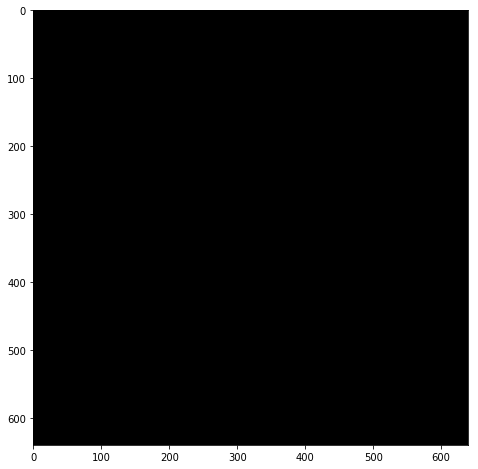

In [7]:
# Test the trained model: generation
%pylab inline
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_latent])
x_generated = model.decoder(z)[0]

w = h = 128 
n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n, 3))

for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w, :] = x_generated[i*n+j, :].reshape(128, 128, 3)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated)# cmap='gray')


/home/saket/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


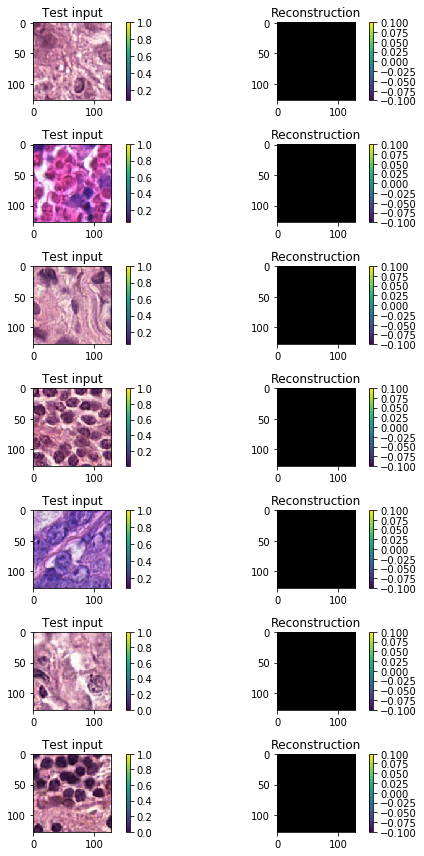

In [11]:
sess = model.session

sess.run(training_init_op)    
        
x_sample, _ = sess.run(training_next_batch)
x_sample = np.reshape(x_sample, (-1, 128*128*3))
x_reconstruct = model.reconstruct(x_sample)


plt.figure(figsize=(8, 12))
for i in range(7):

    plt.subplot(7, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(128, 128, 3))
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(7, 2, 2*i + 2)
    plt.imshow(x_reconstruct[0][i].reshape(128, 128, 3))
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

In [12]:
x_reconstruct

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)]

In [ ]:
z_mu = vae.encoder(x_sample)[0]
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()


In [ ]:
import tensorflow as tf
config = tf.ConfigProto(
    device_count = {'GPU': 0}
)
const_init_node = tf.constant_initializer(0.)
count_variable = tf.get_variable("count", [], initializer=const_init_node)

init = tf.global_variables_initializer()
sess = tf.Session(config=config)
sess.run(init)

print(sess.run([count_variable]))